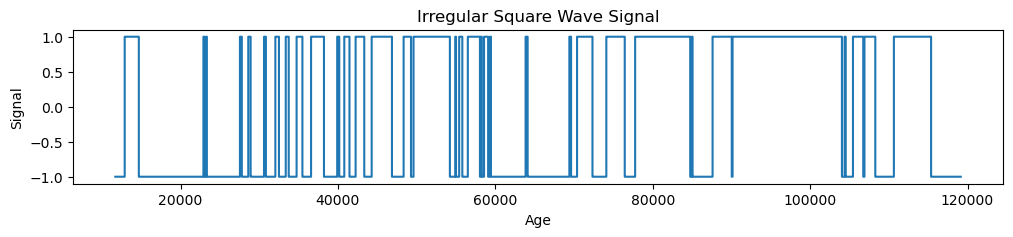

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given ground truth intervals for the low phase (-1)
gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}

# Create an age vector (baseline resolution e.g. every 10 years)
ages = np.arange(11703, 119140, 1)

# Initialize signal at +1
signal = np.ones_like(ages)

# Flip to -1 during the specified low-phase intervals
for start, end in zip(gs_data["start"], gs_data["end"]):
    mask = (ages >= start) & (ages <= end)
    signal[mask] = -1

# Build a DataFrame for clarity
df_sq = pd.DataFrame({"age": ages, "sq": signal})

# Plot the irregular square wave
plt.figure(figsize=(12, 2))
plt.step(df_sq["age"], df_sq["sq"], where="post")
plt.xlabel("Age")
plt.ylabel("Signal")
plt.title("Irregular Square Wave Signal")
plt.show()


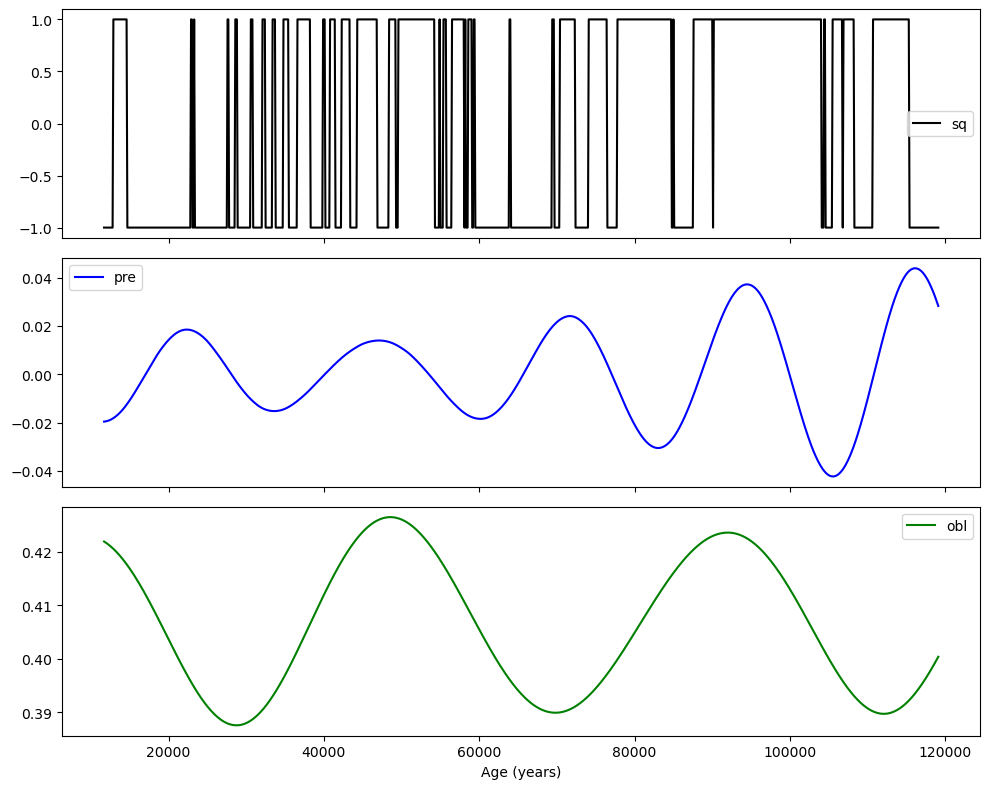

         age   sq
0      11703 -1.0
1      11803 -1.0
2      11903 -1.0
3      12003 -1.0
4      12103 -1.0
...      ...  ...
1070  118703 -1.0
1071  118803 -1.0
1072  118903 -1.0
1073  119003 -1.0
1074  119103 -1.0

[1075 rows x 2 columns]
         age       pre
0      11703 -0.019594
1      11803 -0.019558
2      11903 -0.019507
3      12003 -0.019440
4      12103 -0.019359
...      ...       ...
1070  118703  0.031952
1071  118803  0.031067
1072  118903  0.030157
1073  119003  0.029223
1074  119103  0.028265

[1075 rows x 2 columns]
Length of df_sq_rs: 1075


In [2]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq, df_pre, df_obl = sa.interpolate_data_forcing(df_sq, 100, if_plot=True)
print(df_sq)
print(df_pre)
# print the length of df_sq_rs and df_pre_rs
print('Length of df_sq_rs:', len(df_sq))

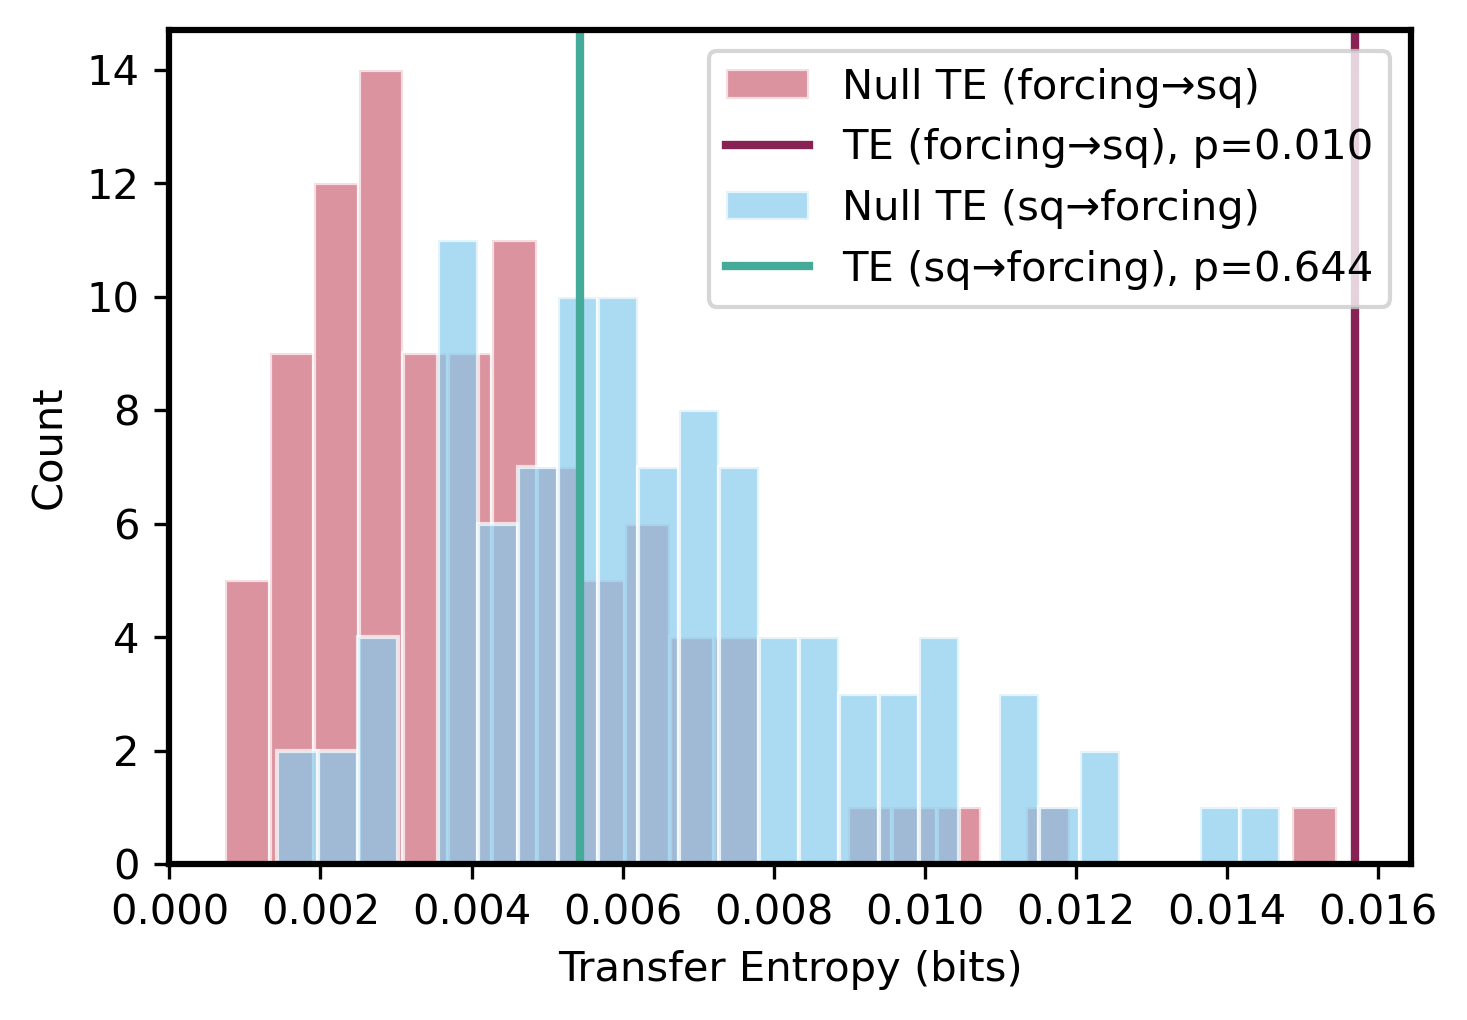

True

In [31]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


pre = df_pre['pre'].values      # source (precession)
sq = df_sq['sq'].values    # target (residual)


result =sa.transfer_entropy_surrogate_test(pre,sq,dpi=300)
result